In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats
import matplotlib.ticker as ticker
import math

import plotly.io as pio
pio.renderers.default = "png"
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score 

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

In [2]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df)

df shape: (2580, 80)


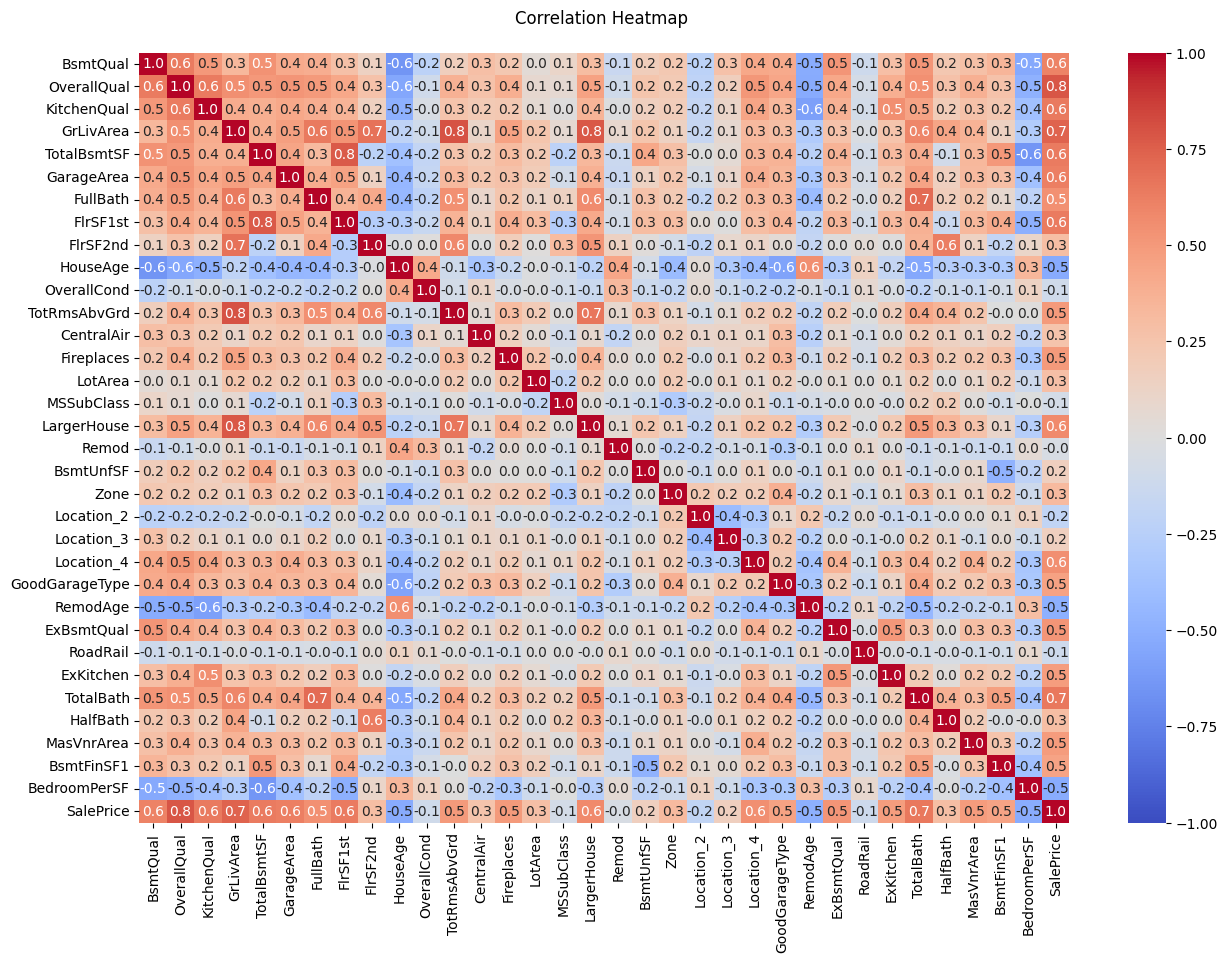

In [3]:
feature_selection = ['BsmtQual' , 'OverallQual' , 'KitchenQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea' , 'FullBath' , 'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'LargerHouse' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location_2', 'Location_3', 'Location_4', 'GoodGarageType',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'ExKitchen' , 'TotalBath', 
                    'HalfBath',# 'ExQual', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

plt.figure(figsize=(15, 10))

corr_mat = data[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [4]:
skewness = data[feature_selection].skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 0.75])
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

data['LotArea'] = np.log(data['LotArea'])

LotArea         13.647537
ExKitchen        4.212534
RoadRail         3.690437
ExBsmtQual       3.571738
MasVnrArea       2.740317
Location_4       1.937549
MSSubClass       1.339800
Location_3       1.083856
FlrSF1st         1.045575
BsmtUnfSF        0.981279
GrLivArea        0.943880
FlrSF2nd         0.804334
BedroomPerSF     0.767331
Zone            -1.733407
CentralAir      -3.705920
dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

In [6]:
temp = pd.concat([X_train, y_train], axis=1)
temp['PriceSF'] = temp['SalePrice']/temp['TotalSF']

In [7]:
#Location Feature

temp = pd.concat([X_train, y_train], axis=1)
temp['PriceSF'] = temp['SalePrice']/temp['TotalSF']

temp.groupby('Neighborhood').PriceSF.median().sort_values()

Neighborhood
SWISU       53.254889
OldTown     58.290155
MeadowV     59.142193
Edwards     60.200669
IDOTRR      60.674157
NPkVill     63.563133
BrkSide     64.021142
NAmes       64.596828
BrDale      65.275201
NWAmes      66.558787
Sawyer      67.550562
Blmngtn     69.912664
Landmrk     70.256410
SawyerW     70.985401
Mitchel     71.605960
ClearCr     73.146837
Blueste     74.289406
CollgCr     74.971165
Crawfor     75.260556
Gilbert     75.987842
StoneBr     80.516521
Somerst     80.934195
Timber      81.463675
Veenker     83.282429
NridgHt     83.674065
NoRidge     83.984693
Greens      86.447897
GrnHill    109.853529
Name: PriceSF, dtype: float64

# Model

### Standardization

In [8]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

## Linear Regression

In [9]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.926  0.9287 0.9306 0.9322 0.9476]
Mean shuffled cross validation score: 0.933
RMSE Shuffled cross validation score: [0.0958 0.0988 0.0924 0.0975 0.0839]
RMSE Mean shuffled cross validation score: 0.0937


In [10]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9314
RMSE Test score: 0.098


In [11]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16577.260068863634
17026.47152468649


In [12]:
train_mape = mean_absolute_percentage_error(np.exp(y_train), np.exp(yhat_train))
test_mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(yhat_test))

print(train_mape)
print(test_mape)

0.06908118788333804
0.07359562104840388


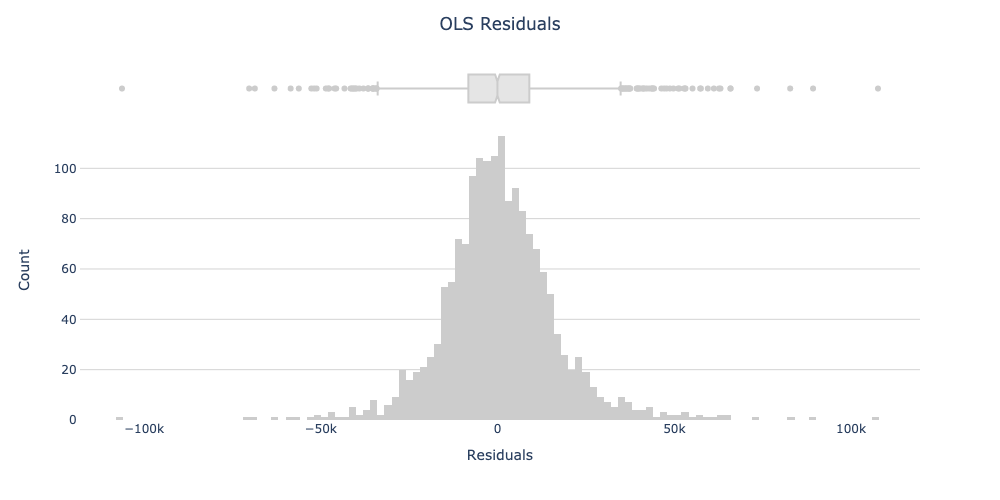

In [13]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

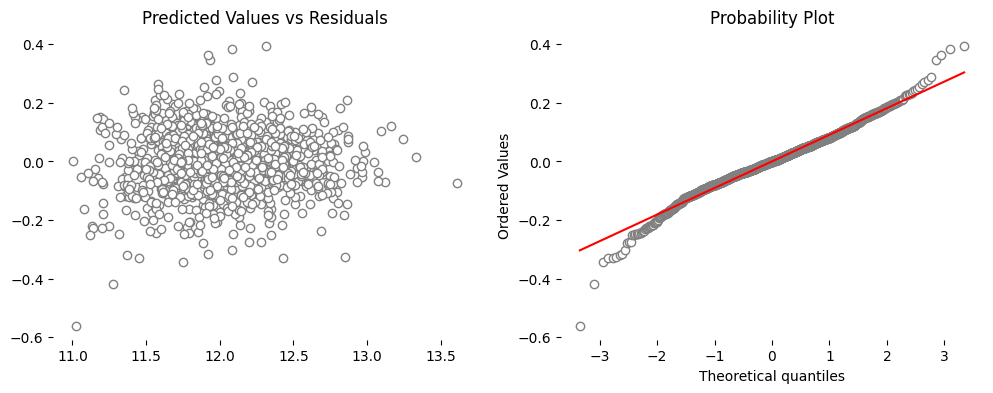

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [15]:
res = stats.shapiro(residuals)
res.statistic

0.9815422296524048

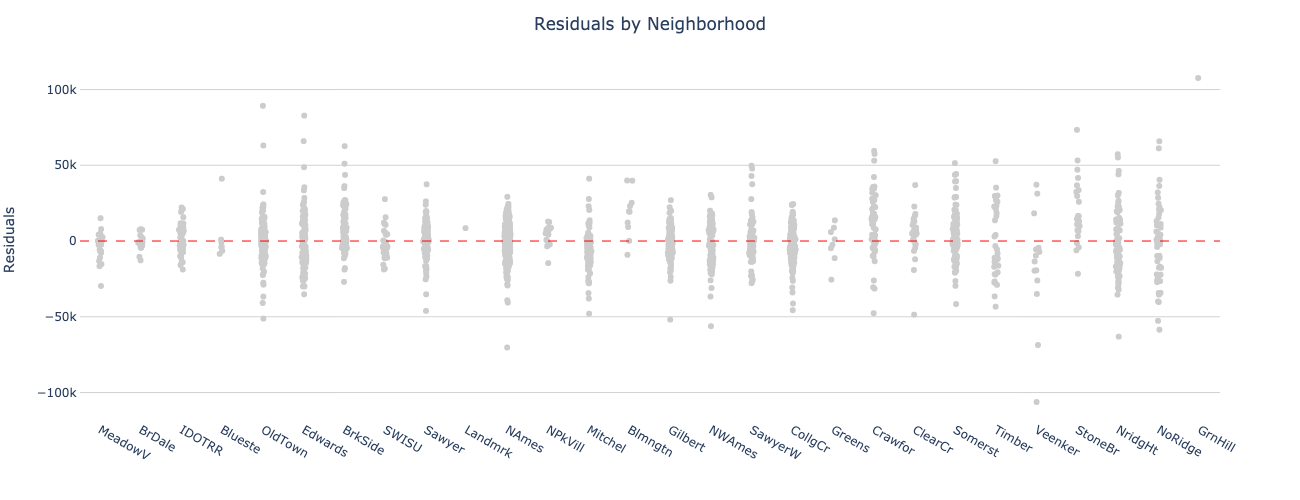

In [16]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

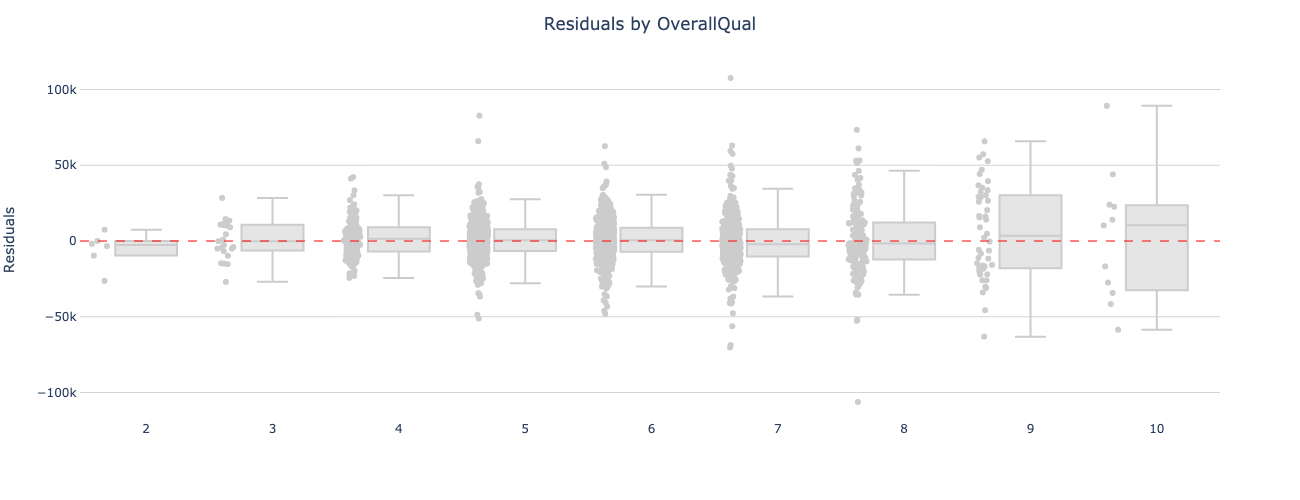

In [17]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

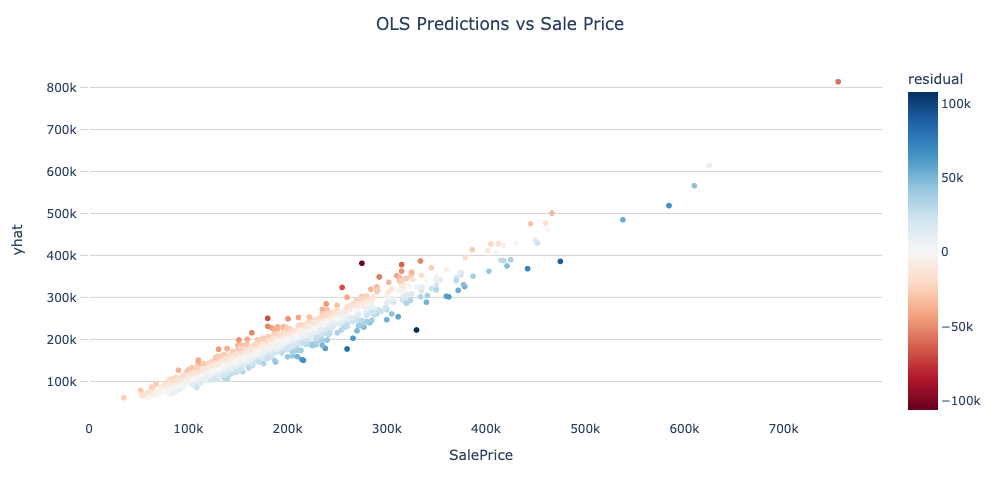

In [18]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [19]:
lasso = LassoCV(cv=3)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Best alpha: 0.00090542266527849
RMSE: 0.0982969275527312


In [20]:
kf = KFold(n_splits=2, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9295 0.9364]
Mean shuffled cross validation score: 0.933
RMSE Shuffled cross validation score: [0.0961 0.0918]
RMSE Mean shuffled cross validation score: 0.094


In [21]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16562.73603084466
17103.87650005853


In [22]:
train_mape = mean_absolute_percentage_error(np.exp(y_train), np.exp(yhat_train))
test_mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(yhat_test))

print(train_mape)
print(test_mape)

0.06916969082973747
0.07388148865917676


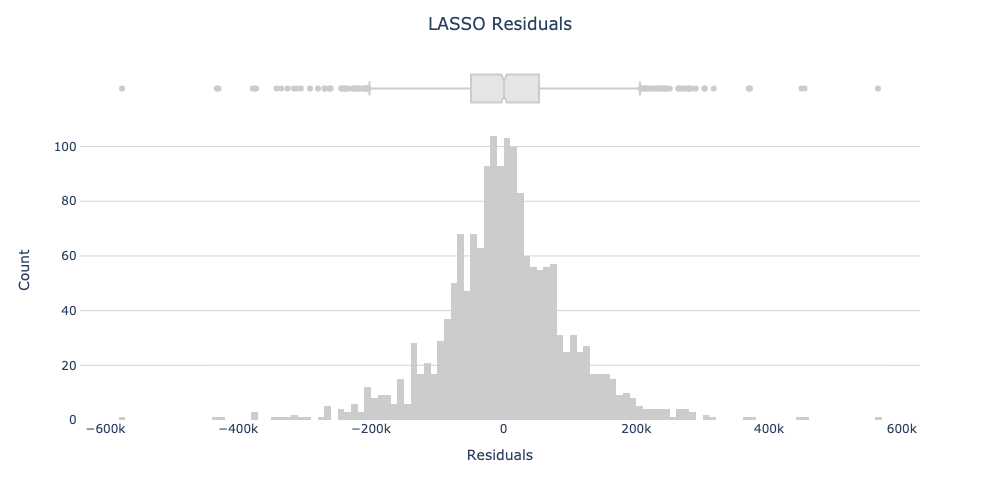

In [23]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

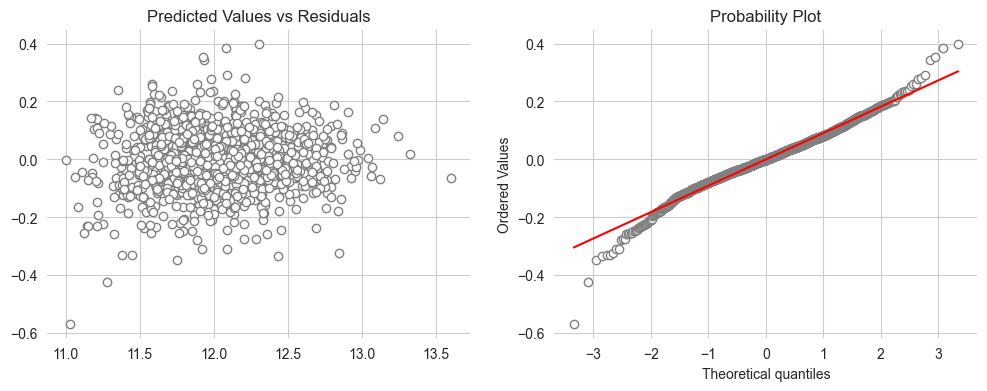

In [24]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [25]:
res = stats.shapiro(residuals)
res.statistic

0.9806006550788879

## Ridge

In [26]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Best alpha: 10.0
RMSE: 0.09794712044358453


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9259 0.9287 0.931  0.9327 0.9473]
Mean shuffled cross validation score: 0.9331
RMSE Shuffled cross validation score: [0.0958 0.0988 0.0921 0.0972 0.0841]
RMSE Mean shuffled cross validation score: 0.0936


In [28]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16574.63980708449
17024.62102551669


In [29]:
train_mape = mean_absolute_percentage_error(np.exp(y_train), np.exp(yhat_train))
test_mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(yhat_test))

print(train_mape)
print(test_mape)

0.06907525673315312
0.07351370316218514


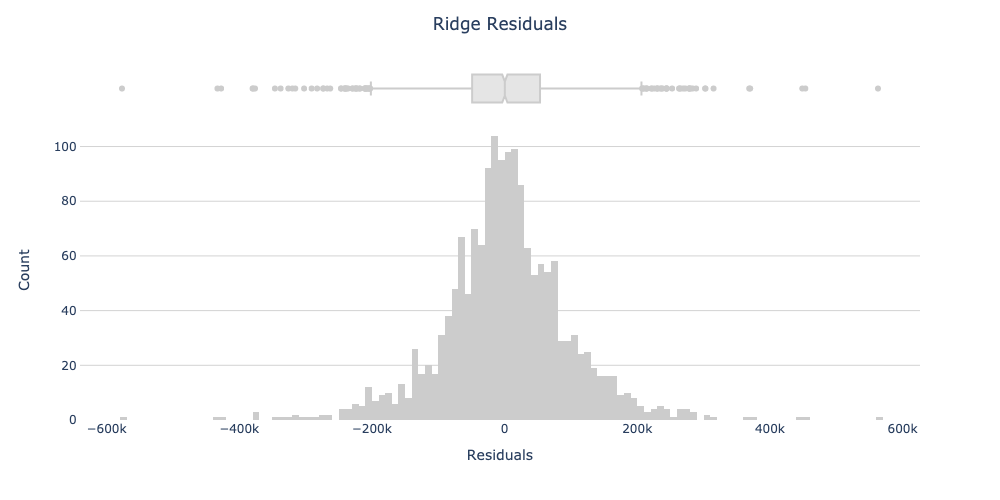

In [30]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

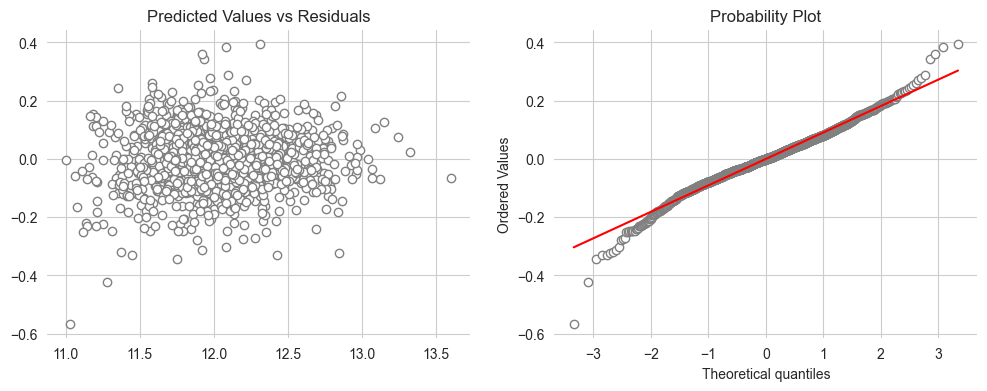

In [31]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [32]:
res = stats.shapiro(residuals)
res.statistic

0.9813001155853271

## Stats model

In [33]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                    Fireplaces + LotArea + MSSubClass + Remod +\
                    BsmtUnfSF + Zone + Location_2 + Location_3 + Location_4 +\
                    RemodAge + ExBsmtQual + RoadRail + ExKitchen + HalfBath + BedroomPerSF +\
                    MasVnrArea + BsmtFinSF1 +\
                    GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0.9/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     793.5
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:01:19   Log-Likelihood:                 1615.3
No. Observations:                1678   AIC:                            -3169.
Df Residuals:                    1647   BIC:                            -3000.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0174      0.003   4769.815      0.000      12.012      12.022
BsmtQual                 0.0089      0.004      2.021      0.043       0.000       0.017
OverallQual              0.0917      0.004     22.676      0.000       0.084       0.100
GrLivArea                0.0816      0.025      3.270      0.001       0.033       0.131
TotalBsmtSF              0.0518      0.007      7.561      0.000       0.038       0.065
GarageArea               0.0246      0.003      8.142      0.000       0.019       0.031
FullBath                -0.0012      0.004     -0.319      0.750      -0.008       0.006
FlrSF1st                 0.0266      0.019      1.385      0.166      -0.011       0.064
FlrSF2nd                 0.0370      0.022      1.669      0.095      -0.006       0.081
HouseAge                -0.0515      0.005     -9.576      0.000      -0.062      -0.041
OverallCond              0.0506      0.003     16.686      0.000       0.045       0.057
TotRmsAbvGrd             0.0002      0.005      0.039      0.969      -0.009       0.009
CentralAir               0.0184      0.003      6.991      0.000       0.013       0.024
Fireplaces               0.0216      0.003      7.768      0.000       0.016       0.027
LotArea                  0.0438      0.003     12.707      0.000       0.037       0.051
MSSubClass              -0.0033      0.003     -1.065      0.287      -0.009       0.003
Remod                   -0.0035      0.003     -1.156      0.248      -0.009       0.002
BsmtUnfSF               -0.0213      0.005     -3.930      0.000      -0.032      -0.011
Zone                     0.0154      0.003      4.964      0.000       0.009       0.022
Location_2               0.0049      0.004      1.279      0.201      -0.003       0.012
Location_3               0.0268      0.004      6.574      0.000       0.019       0.035
Location_4               0.0353      0.004      8.292      0.000       0.027       0.044
RemodAge                -0.0222      0.004     -6.163      0.000      -0.029      -0.015
ExBsmtQual               0.0078      0.003      2.455      0.014       0.002       0.014
RoadRail                -0.0109      0.002     -4.673      0.000      -0.016      -0.006
ExKitchen                0.0110      0.003      4.029      0.000       0.006       0.016
HalfBath                 0.0013      0.003      0.379      0.705      -0.005       0.008
BedroomPerSF            -0.0145      0.004     -3.988      0.000      -0.022      -0.007
MasVnrArea               0.0036      0.003      1.329      0.184      -0.002       0.009
BsmtFinSF1               0.0184      0.006      3.302      0.001       0.007       0.029
GrLivArea:Fireplaces    -0.0043      0.002     -1.733      0.083      -0.009       0.001
=========================================================

In [34]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

mape_train = mean_absolute_percentage_error(np.exp(y_train), np.exp(yhat_train))
mape_test = mean_absolute_percentage_error(np.exp(y_test), np.exp(yhat_test))

print(train_rmse_non_log)
print(test_rmse_non_log)
print('\n')
print(mape_train)
print(mape_test)

16737.62430195668
17082.016514282554


0.07003076540766713
0.07375300085587602


In [35]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

0.09240748691349449
0.09838782205857749


## Interactions with Location

In [36]:
feature_selection = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

In [37]:
data = df_engineered(df, Reg=False)

data['LotArea'] = np.log(data['LotArea'])

In [38]:
location=1
temp = data[data.Location==location]

X_train_loc, X_test_loc, y_train_loc, y_test_loc = \
    train_test_split(temp.drop(columns='SalePrice'), temp[['SalePrice']], test_size=0.30, random_state=42)

### Standardization

In [39]:
feature_selection_2 = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'Remod',
                    'BsmtUnfSF' , 'Zone' ,
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

In [40]:
scaler = StandardScaler()

X_train_loc = X_train_loc.reset_index(drop=True)
X_test_loc = X_test_loc.reset_index(drop=True)

y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)

In [41]:
X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 + \
                        GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

results_fu = model.fit()

if location == 4:
        alpha = 0.1
        l1 = 1
elif location == 1:
    alpha = 10
    l1 = 0
elif location == 2:
    alpha = 5
    l1 = 1
else:
    alpha=0
    l1 = 0


n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=l1, alpha=alpha/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     92.30
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          1.01e-152
Time:                        22:01:19   Log-Likelihood:                 329.85
No. Observations:                 424   AIC:                            -603.7
Df Residuals:                     396   BIC:                            -490.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.7006      0.006   1989.768      0.000      11.689      11.712
BsmtQual                 0.0070      0.008      0.837      0.403      -0.009       0.023
OverallQual              0.0680      0.007      9.084      0.000       0.053       0.083
GrLivArea                0.0443      0.034      1.319      0.188      -0.022       0.110
TotalBsmtSF              0.0464      0.016      2.910      0.004       0.015       0.078
GarageArea               0.0408      0.007      6.212      0.000       0.028       0.054
FullBath                 0.0004      0.008      0.049      0.961      -0.016       0.017
FlrSF1st                 0.0411      0.021      1.942      0.053      -0.001       0.083
FlrSF2nd                 0.0572      0.025      2.273      0.024       0.008       0.107
HouseAge                -0.0616      0.010     -6.017      0.000      -0.082      -0.041
OverallCond              0.0845      0.008     11.041      0.000       0.069       0.100
TotRmsAbvGrd             0.0230      0.012      1.910      0.057      -0.001       0.047
CentralAir               0.0173      0.007      2.579      0.010       0.004       0.031
Fireplaces               0.0242      0.007      3.480      0.001       0.011       0.038
LotArea                  0.0479      0.009      5.356      0.000       0.030       0.066
MSSubClass              -0.0051      0.008     -0.618      0.537      -0.021       0.011
Remod                   -0.0063      0.009     -0.704      0.482      -0.024       0.011
BsmtUnfSF               -0.0134      0.016     -0.843      0.400      -0.045       0.018
Zone                     0.0177      0.007      2.675      0.008       0.005       0.031
RemodAge                -0.0208      0.007     -2.988      0.003      -0.035      -0.007
ExBsmtQual               0.0024      0.006      0.376      0.707      -0.010       0.015
RoadRail                -0.0143      0.006     -2.433      0.015      -0.026      -0.003
KitchenQual              0.0045      0.007      0.685      0.494      -0.008       0.017
HalfBath                -0.0036      0.007     -0.535      0.593      -0.017       0.010
BedroomPerSF            -0.0092      0.008     -1.192      0.234      -0.024       0.006
MasVnrArea               0.0009      0.006      0.146      0.884      -0.011       0.013
BsmtFinSF1               0.0091      0.015      0.611      0.542      -0.020       0.039
GrLivArea:Fireplaces     0.0084      0.005      1.613      0.108      -0.002       0.019
==============================================================================
Omnibus:                       25.856   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.728
Skew:                          -0.409   Prob(JB):                     3.20e-10
Kurtosis

In [42]:
yhat_train_loc = final.predict(X_train_scaled_loc)
yhat_test_loc = final.predict(X_test_scaled_loc)

train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

15055.618506727706
15511.499503180907


In [43]:
def my_vectorized_func(m):
    return (m - 1)*np.exp(y_train_loc.values).mean() 

def coefplot(results, variable, location):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)
    coef_df[['[0.025', '0.975]', 'coef']] = coef_df[['[0.025', '0.975]', 'coef']].apply(np.exp)
    coef_df[['[0.025', '0.975]', 'coef']] = coef_df[['[0.025', '0.975]', 'coef']].apply(my_vectorized_func)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors


    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    coef_df = coef_df.drop('Intercept')

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables

    coef_df = coef_df.loc[[variable],:]
    coef_df['Location'] = str(location)
    
    return coef_df

In [44]:
unscaled_coef = final.params[1:]

transformed_coef = []
for i in unscaled_coef:
    j = math.exp(i)
    transformed_coef.append(j)

In [45]:
cols = X_train_scaled_loc.columns.values

coef_effect = [(i - 1)*np.exp(y_train_loc.values).mean() for i in transformed_coef]

var_impact = pd.DataFrame(data=[cols[cols != 'Location'], coef_effect]).T
var_impact.columns = ["variable", "1-unit change"]
var_impact

,variable,1-unit change
0,BsmtQual,883.401711
1,OverallQual,8839.610164
2,GrLivArea,5686.429959
3,TotalBsmtSF,5963.37372
4,GarageArea,5225.061427
5,FullBath,50.130383
6,FlrSF1st,5275.96811
7,FlrSF2nd,7399.437048
8,HouseAge,-7506.856389
9,OverallCond,11076.788251


In [81]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
coef_df = pd.DataFrame()

for location in (1,2,3,4):

    temp = data[data.Location==location]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]

    if location == 4:
        alpha = 0.1
        l1 = 1
    elif location == 1:
        alpha = 10
        l1 = 0
    elif location == 2:
        alpha = 5
        l1 = 1
    else:
        alpha=0
        l1 = 0

    results_fr = model.fit_regularized(L1_wt=l1, alpha=alpha/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    mape_train = mean_absolute_percentage_error(np.exp(y_train_loc), np.exp(yhat_train_loc))
    mape_test = mean_absolute_percentage_error(np.exp(y_test_loc), np.exp(yhat_test_loc))

    #print(train_rmse_non_log)
    #print(test_rmse_non_log)
    print(mape_train)
    print(mape_test)

    coef_plot = coefplot(final, 'Fireplaces',location)
    coef_plot['mean_price'] = np.exp(y_train_loc.values).mean()

    coef_df = pd.concat([coef_df, coef_plot],axis=0)

    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train_loc = pd.concat([df_train_loc, X_train_loc], axis=1)
    df_train = pd.concat([df_train, df_train_loc], axis=0)


    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

0.08675662644214936
0.08884450313190131
0.05947591183399018
0.06715058986206074
0.0577154458662675
0.062038104092368915
0.05957302722429578
0.06294926616626065


In [82]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

mape_train = mean_absolute_percentage_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train))
mape_test = mean_absolute_percentage_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train))

print(train_rmse_non_log)
print(test_rmse_non_log)
print('\n')
print(mape_train)
print(mape_test)

15284.222016628088
16413.61572011304


0.06592727907224728
0.07064557848633428


In [83]:
coef_df['coef_perc'] = coef_df['coef']*100/coef_df['mean_price']
coef_df['[0.025_perc'] = coef_df['[0.025']*100/coef_df['mean_price']
coef_df['0.975]_perc'] = coef_df['0.975]']*100/coef_df['mean_price']
coef_df['errors_perc'] = coef_df['errors']*100/coef_df['mean_price']
coef_df

,coef,std err,t,P>|t|,[0.025,0.975],errors,variables,Location,mean_price,coef_perc,[0.025_perc,0.975]_perc,errors_perc
,,,,,,,,,,,,,,
Fireplaces,3076.963985,0.007,3.480,0.001,1389.392598,4865.223635,1687.571388,Fireplaces,1,125614.995283,2.449520,1.106072,3.873123,1.343447
Fireplaces,3152.607926,0.004,4.433,0.000,1734.890165,4615.289806,1417.717761,Fireplaces,2,156851.432916,2.009932,1.106072,2.942459,0.903860
Fireplaces,5476.012439,0.005,5.930,0.000,3726.103232,7322.002898,1749.909207,Fireplaces,3,194253.544419,2.819003,1.918165,3.769302,0.900838
Fireplaces,4485.829581,0.007,2.413,0.017,805.189145,8161.632014,3680.640437,Fireplaces,4,267993.988235,1.673855,0.300450,3.045453,1.373404


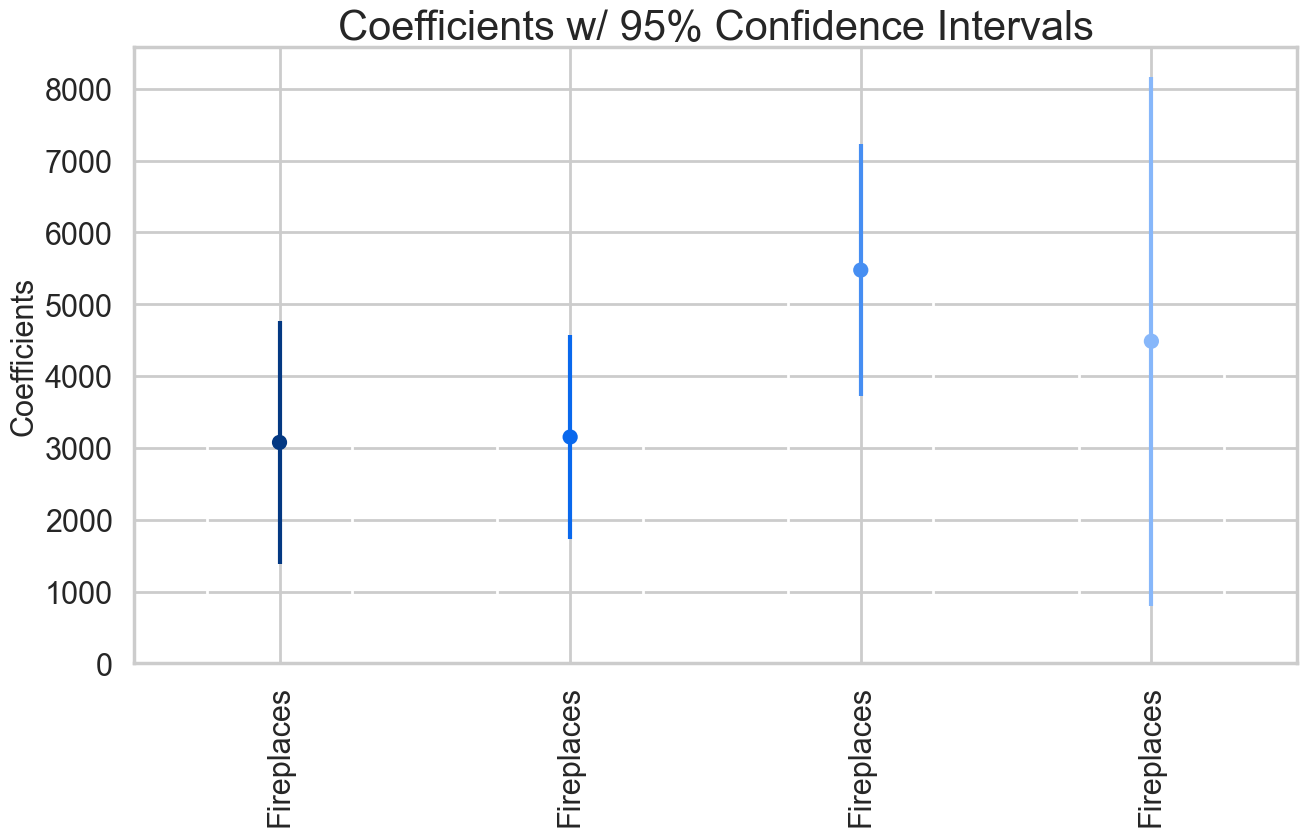

In [84]:
# Set sns plot style back to 'poster'
# This will make bars wide on plot
sns.set_context("poster")

# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15, 8))

# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
c_map = {'1': '#033882', '2': '#0968ed', '3':'#468ef2', '4':'#87b7fa'}
coef_df.plot(x='variables', y='coef', kind='bar',
                ax=ax, color='none', fontsize=22, 
                ecolor=[c_map[_] for _ in coef_df.Location], capsize=0,
                yerr='errors', legend=False)

# Set title & labels
plt.title('Coefficients w/ 95% Confidence Intervals',fontsize=30)
ax.set_ylabel('Coefficients',fontsize=22)
ax.set_xlabel('',fontsize=22)

# Coefficients
ax.scatter(x=np.arange(coef_df.shape[0]), 
            marker='o', s=80, color=[c_map[_] for _ in coef_df.Location], 
            y=coef_df['coef'])

# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)

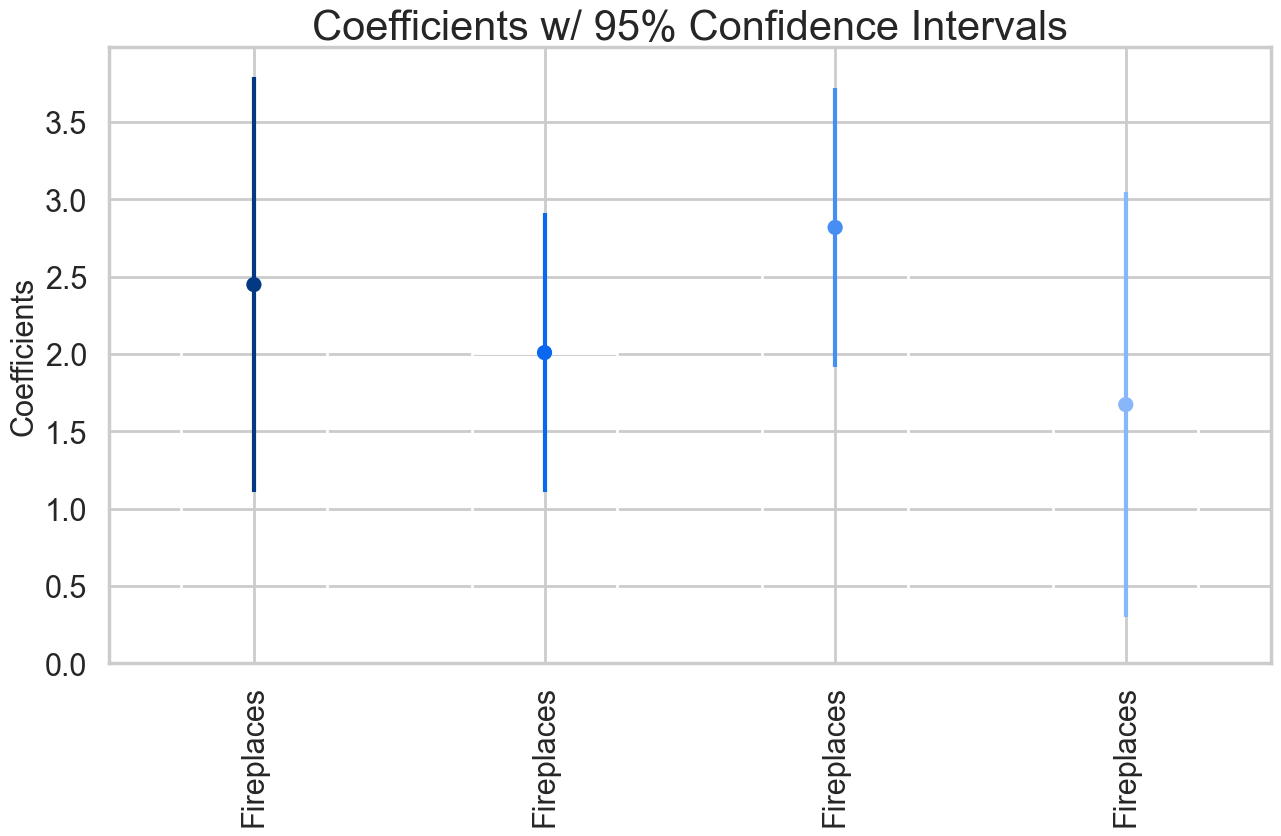

In [85]:
# Set sns plot style back to 'poster'
# This will make bars wide on plot
sns.set_context("poster")

# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15, 8))

# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
c_map = {'1': '#033882', '2': '#0968ed', '3':'#468ef2', '4':'#87b7fa'}
coef_df.plot(x='variables', y='coef_perc', kind='bar',
                ax=ax, color='none', fontsize=22, 
                ecolor=[c_map[_] for _ in coef_df.Location], capsize=0,
                yerr='errors_perc', legend=False)

# Set title & labels
plt.title('Coefficients w/ 95% Confidence Intervals',fontsize=30)
ax.set_ylabel('Coefficients',fontsize=22)
ax.set_xlabel('',fontsize=22)

# Coefficients
ax.scatter(x=np.arange(coef_df.shape[0]), 
            marker='o', s=80, color=[c_map[_] for _ in coef_df.Location], 
            y=coef_df['coef_perc'])

# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)

In [64]:
data['Location'].value_counts()

Location
2    799
3    628
1    606
4    365
Name: count, dtype: int64